# Library

In [19]:
import os
import glob
import json
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import cv2

# check image

In [20]:
image_files = glob.glob('./data/*.jpg')
image_file = image_files[0]

(3024, 4032, 3)


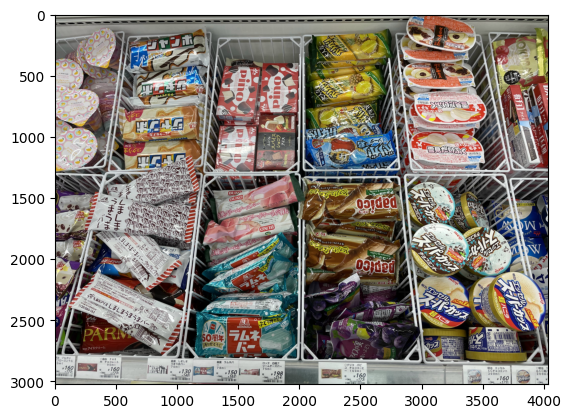

In [21]:
im = Image.open(image_file)
im_array = np.array(im)
print(im_array.shape)

plt.imshow(im)

# create save folders

In [22]:
croped_images_folder = './cropped_data/images/'
croped_labels_folder = './cropped_data/labels/'
check_croped_images_folder = './cropped_data/check_croping/'

for folder in [croped_images_folder, croped_labels_folder, check_croped_images_folder]:
    os.makedirs(folder, exist_ok=True)

# make dictionalies (label2index, index2label)

In [23]:
# labelme
json_file = image_file.replace('.jpg', '.json')
with open(json_file, 'r') as f:
    labelme_data = json.load(f)


In [24]:

label_list = []

for shape in labelme_data['shapes']:
    if shape['label'] not in label_list:
        label_list.append(shape['label'])

label2index = {}
index2label = {}

for i, label in enumerate(set(label_list)):
    label2index[label] = i
    index2label[i] = label
print(label2index)
print(index2label)

{'peech mango': 0, 'whitepeach cream cheese': 1, 'parm': 2, 'ramune bar': 3, 'spice chocolate': 4, 'mow': 5, 'new jumbo': 6, 'fuits of ice': 7, 'super cup choco mint': 8, 'super cup banilla': 9, 'kokubata': 10, 'yukimi komeda': 11, 'garigari soda': 12, 'jumbo': 13, 'papico': 14, 'ita choco': 15, 'garigari pine': 16, 'shima uma bar': 17, 'yukimi daifuku': 18, 'pino': 19, 'azuki': 20}
{0: 'peech mango', 1: 'whitepeach cream cheese', 2: 'parm', 3: 'ramune bar', 4: 'spice chocolate', 5: 'mow', 6: 'new jumbo', 7: 'fuits of ice', 8: 'super cup choco mint', 9: 'super cup banilla', 10: 'kokubata', 11: 'yukimi komeda', 12: 'garigari soda', 13: 'jumbo', 14: 'papico', 15: 'ita choco', 16: 'garigari pine', 17: 'shima uma bar', 18: 'yukimi daifuku', 19: 'pino', 20: 'azuki'}


# define class
crop images by 

In [25]:
class Crop_image_labelme2yolo():
    def __init__(self, out_y, out_x, overlap, output_img_folder, output_yolo_folder) -> None:
        self.out_y = out_y
        self.out_x = out_x
        self.overlap = overlap
        self.output_img_folder = output_img_folder
        self.output_yolo_folder = output_yolo_folder

    def cropping(self, labelme_path):
        # read json file
        with open(labelme_path, 'r') as f:
            labelme_data = json.load(f)
        # get basename of file to save iamges & YOLO.txt
        basename = os.path.basename(labelme_path).split('.')[0]

        # get path of images
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            image_file_path = labelme_path.replace('.json', f'{ext}')
            if os.path.isfile(image_file_path):
                break
            else:
                pass
        # open images, get height & width
        img = Image.open(image_file_path)
        img_array = np.array(img)
        in_y, in_x, _ = img_array.shape

        num_images_y = in_y // self.out_y
        num_images_x = in_x // self.out_x

        # if crop images are lack at righet & bottom, num of image +1
        if in_y - num_images_y * (self.out_y - self.overlap) > self.overlap:
            num_images_y += 1
        if in_x- num_images_x * (self.out_x - self.overlap) > self.overlap:
            num_images_x += 1

        # set index to rename save-file name , when save crop image and YOLO.txt
        index = 0
        for i in range(num_images_y):
            for j in range(num_images_x):
                start_y = np.maximum(0, i * (self.out_y - self.overlap))
                start_x = np.maximum(0, j * (self.out_x - self.overlap))
                end_y = i * (self.out_y - self.overlap) + self.out_y
                end_x = j * (self.out_x - self.overlap) + self.out_x
                output_array = img_array[start_y: end_y, start_x: end_x]
                
                img = cv2.copyMakeBorder(output_array, 
                                   0, self.out_y - output_array.shape[0], 
                                   0, self.out_x - output_array.shape[1], 
                                   cv2.BORDER_CONSTANT, 
                                   0)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                yolo_list = [] # strage anotation data / image
                # get labelme data to YOLO
                for shape in labelme_data['shapes']:
                    _yolo_list = []
                    # get point datas eg.[[start x, start y],[end x, end y]]
                    for point in shape['points']:
                        x, y = point # x, yの順
                        # over 0 and under crop size
                        crop_y = np.minimum(self.out_y, np.maximum(0, y - start_y))
                        crop_x = np.minimum(self.out_x, np.maximum(0, x - start_x))
                        _yolo_list.append(crop_x / self.out_x) # x y の順
                        _yolo_list.append(crop_y / self.out_y)
                    sx, sy, ex, ey = _yolo_list
                    if sx != ex and sy != ey:
                        yolo_list.append([label2index[shape['label']], sx, sy, ex, ey])

                # save image and YOLOtxt
                if len(yolo_list) != 0:
                    cv2.imwrite(self.output_img_folder + f'{basename}_{index:02}.png', img)
                    yolo_df = pd.DataFrame(yolo_list)
                    yolo_df.to_csv(self.output_yolo_folder + f'{basename}_{index:02}.txt', sep=(' '), header=None, index=None)
                index += 1

 

In [26]:
crop_man = Crop_image_labelme2yolo(1280, 1280, 128, croped_images_folder, croped_labels_folder)

In [27]:
crop_man.cropping(json_file)

In [28]:
labelme_data

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'peech mango',
   'points': [[54.0, 226.0], [434.0, 546.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'peech mango',
   'points': [[234.0, 110.0], [582.0, 482.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'peech mango',
   'points': [[6.0, 358.0], [246.0, 634.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'peech mango',
   'points': [[6.0, 606.0], [418.0, 994.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'peech mango',
   'points': [[6.0, 850.0], [150.0, 1074.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'peech mango',
   'points': [[18.0, 914.0], [354.0, 1262.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectan

# chack image and annotation

In [29]:
import matplotlib.pyplot as plt

In [30]:
croped_images = glob.glob(croped_images_folder + '*.png')
croped_labels = glob.glob(croped_labels_folder + '*.txt')

IMG_3895_01.txt


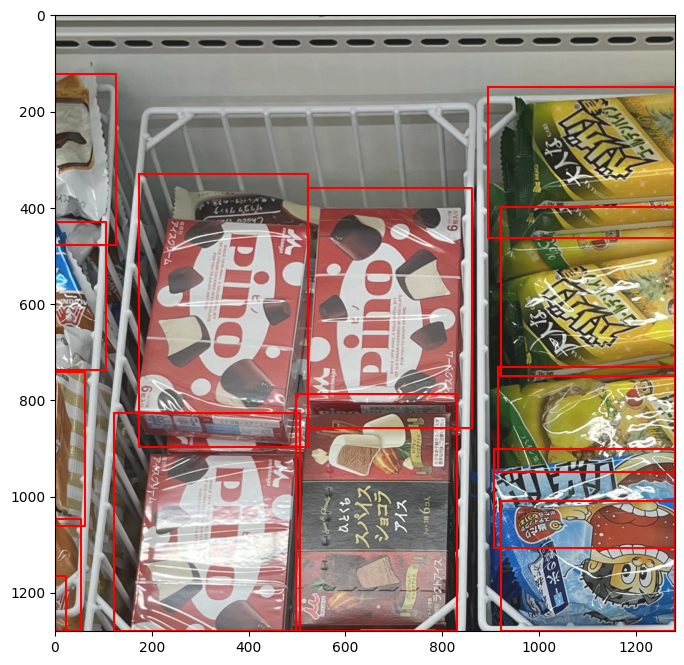

IMG_3895_00.txt


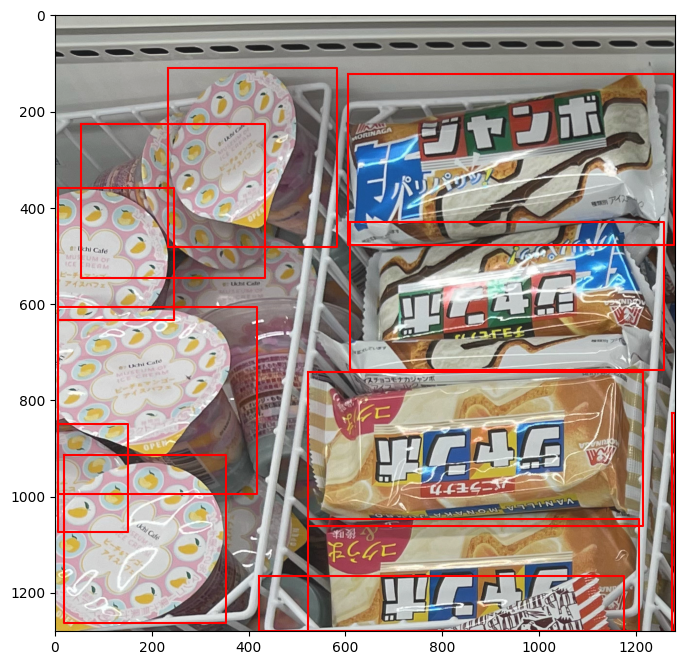

IMG_3895_02.txt


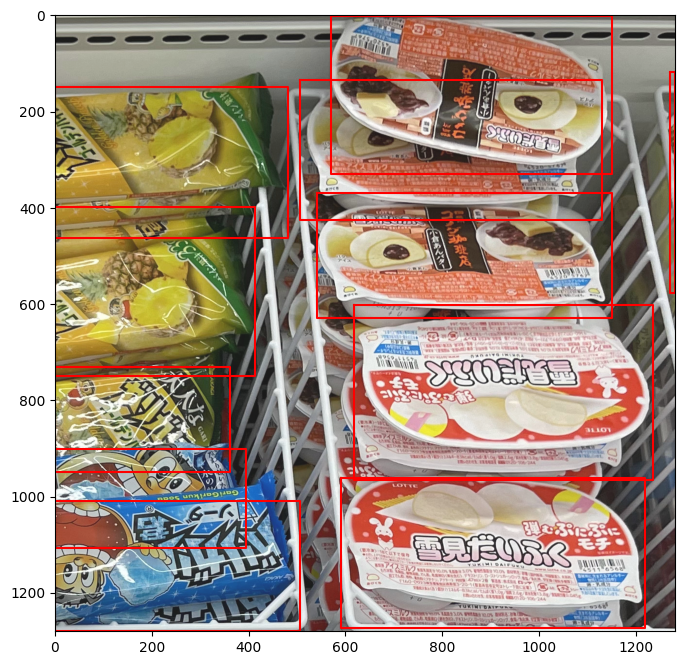

IMG_3895_03.txt


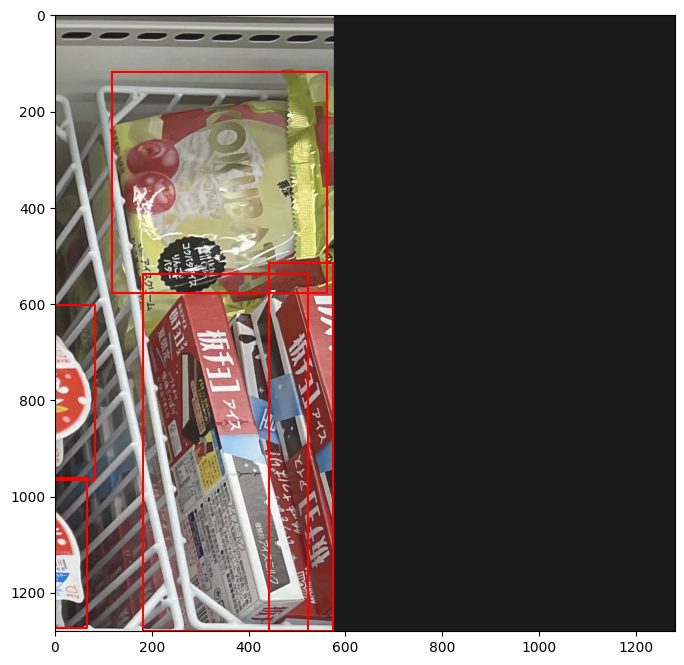

IMG_3895_07.txt


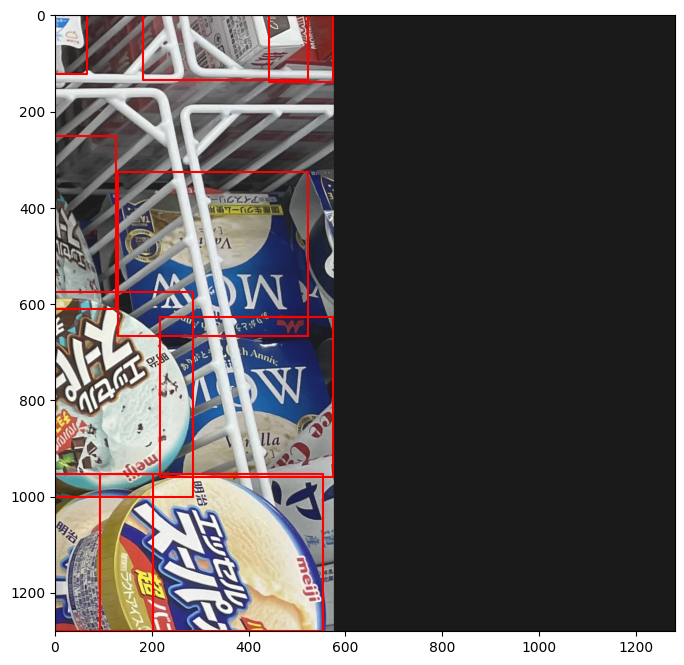

IMG_3895_06.txt


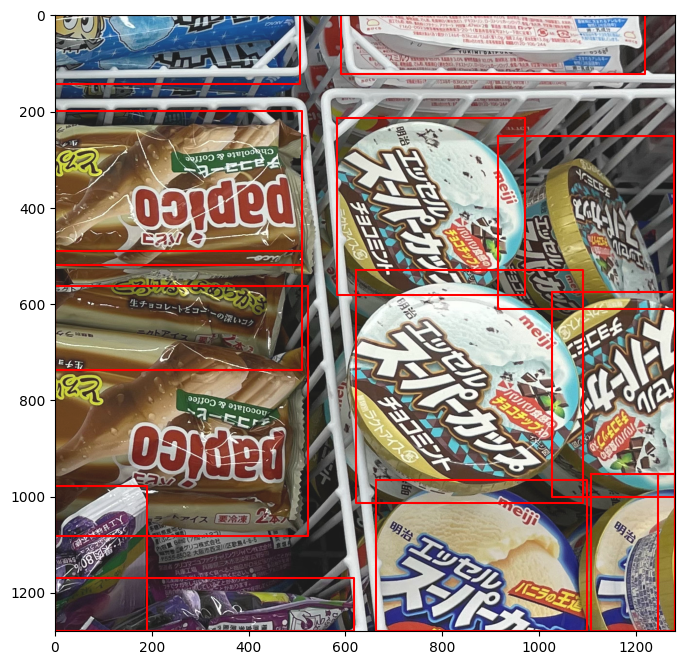

IMG_3895_04.txt


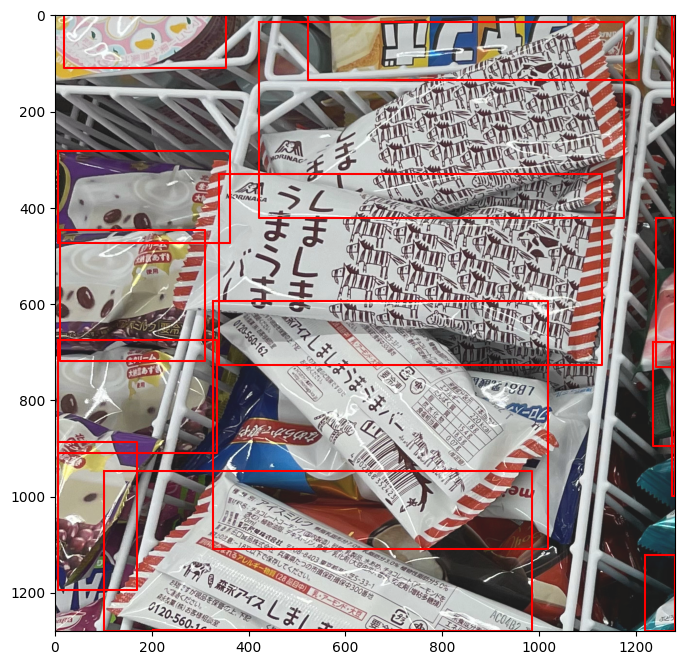

IMG_3895_10.txt


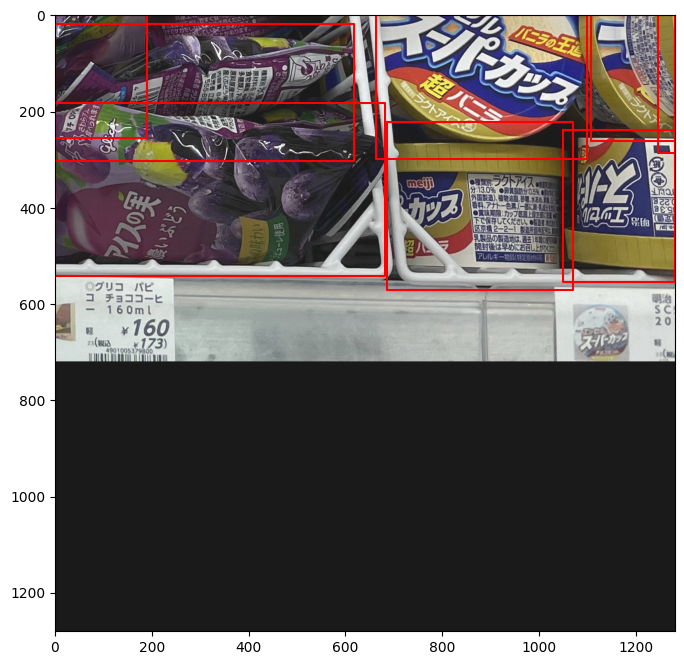

IMG_3895_11.txt


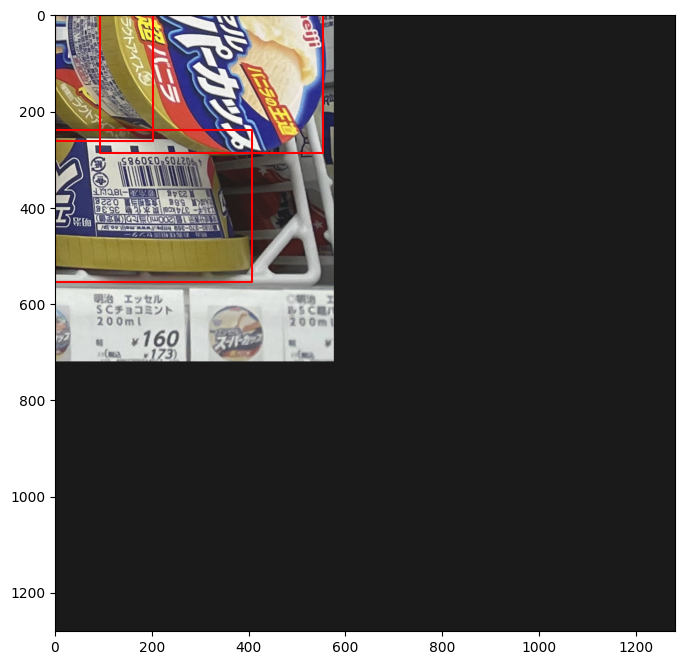

IMG_3895_05.txt


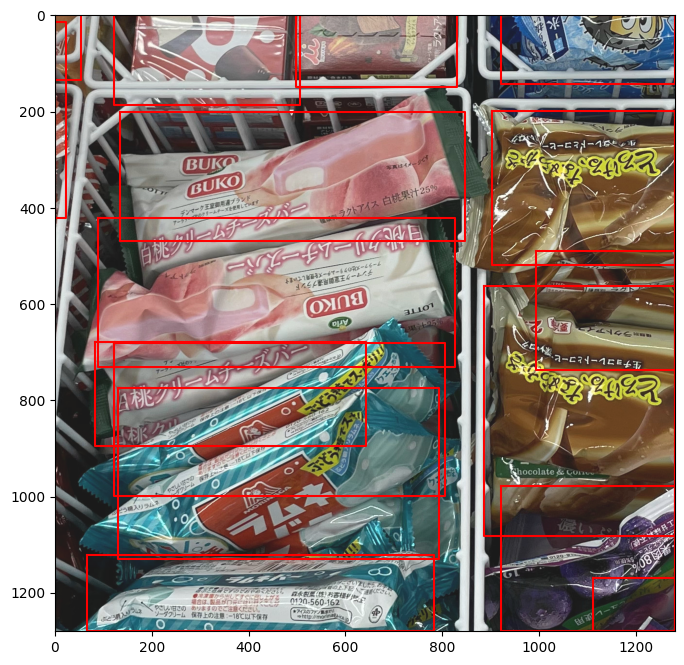

IMG_3895_08.txt


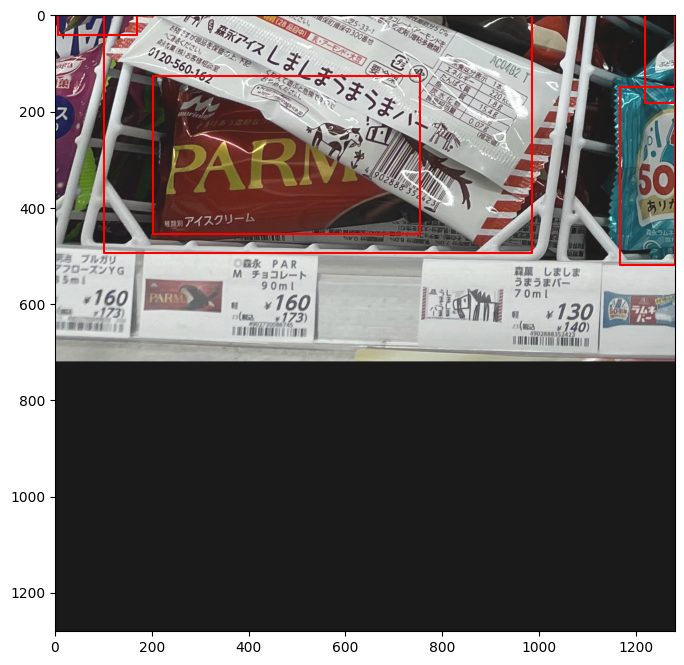

IMG_3895_09.txt


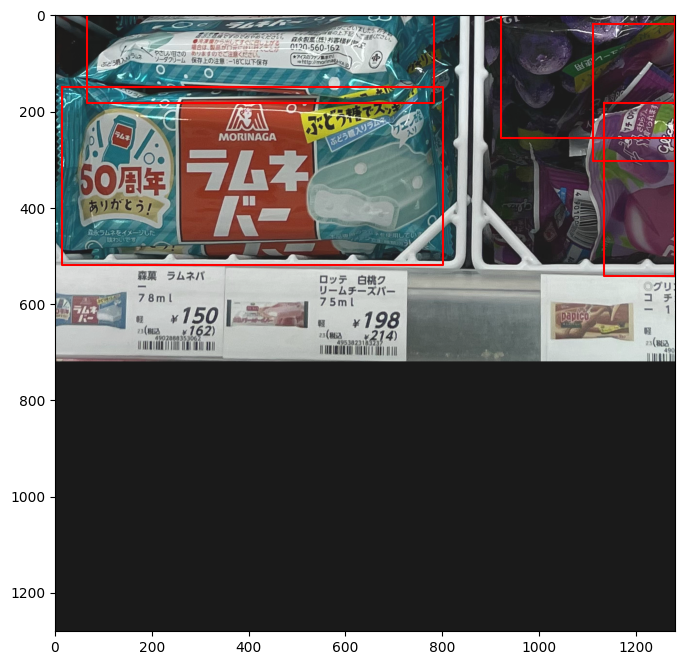

In [36]:
for croped_image in croped_images:
    img = Image.open(croped_image)
    img_array = np.array(img)
    h, w, _ = img_array.shape
    # print(h, w)
    basename = os.path.basename(croped_image).replace('.png', '.txt')
    print(basename)
    croped_label = croped_labels_folder + basename

    os.path.isfile(croped_label)

    df = pd.read_csv(croped_label, header=None, sep=' ')
    
    ano_array = np.array(df)

    plt.figure(figsize=(8,8))
    for ano in ano_array:
        l, sx, sy, ex, ey = ano
        plt.plot([sx*w,sx*w,ex*w,ex*w,sx*w], [sy*h,ey*h,ey*h,sy*h,sy*h], color='red')
    plt.imshow(img_array, aspect='auto', alpha=0.9)
    plt.xlim(0, w,)
    plt.ylim(h, 0)
    plt.savefig(check_croped_images_folder + basename.replace('.txt', '') + '.png')
    plt.show()